The GAN (Generative Adversarial Networks) model may produce different results even when using exactly the same code in different runs, and this is mainly due to the following factors:

Randomness: 
The training process of GANs involves a large number of random operations. For example, the input to the generator network is typically random noise (sampled from a normal or uniform distribution), and this randomness can lead to the model learning slightly different data distributions each time. Additionally, if data augmentation techniques are used, the way data is augmented each time can also be random.

Weight Initialization: 
Before the neural network model begins training, its parameters need to be initialized, a process that is usually based on some kind of random strategy. Different initial parameter settings can cause the model to converge along different optimization paths, thus affecting the final outcome.

Batch Order: 
When using batch gradient descent for training, the order of samples within each epoch influences the learning process. Even when training on the same dataset, the method and order of batch division may differ between runs, which can impact the loss function values and the quality of generated images.

Numerical Stability Issues: 
There is an inherent margin of error in floating-point arithmetic, especially in complex deep learning models where a large number of calculations are performed continuously over long periods. These small differences can accumulate over time and ultimately manifest in the output results.

To reduce the randomness in GAN training and make the results as similar as possible when running the same code, the following methods can be adopted:

Fixing Random Seeds:
Before starting the training, set a fixed random seed. This includes setting the global random seed for Python, the random seed for NumPy, and the random seed for the deep learning framework PyTorch using torch.manual_seed(seed).

Fixing Dataset Order:
If a data loader is used to read the data, ensure that the order of the data is the same every time you train. This can be achieved by fixing the random seed of the data loader or by disabling the shuffling feature directly.

Fixing Weight Initialization:
Use the same strategy and parameters for weight initialization, and it's best to fix its random seed as well. This ensures that the model starts training from the same initial state each time.

Controlling Data Augmentation:
If data augmentation techniques are applied, make sure that the exact same data augmentation transformations are applied to the same input sample every time. This might also involve fixing the related random seeds.

Batch Normalization Layers:
If network includes batch normalization layers, ensure that their randomness is turned off in evaluation mode. 

training start!
Epoch [30/200], D Loss: -2.7473, G Loss: 4.9980


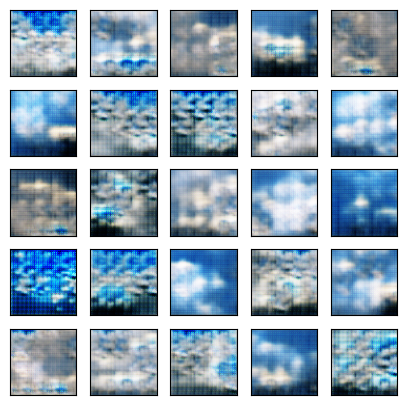

Epoch [60/200], D Loss: -1.2447, G Loss: 0.4721


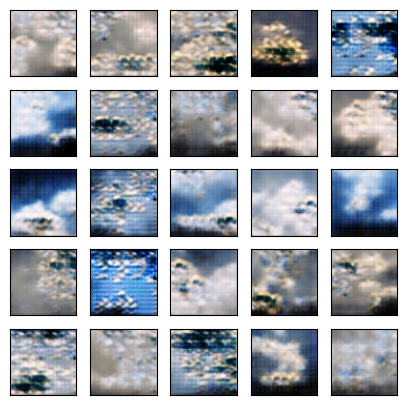

Epoch [90/200], D Loss: -0.9862, G Loss: -1.3577


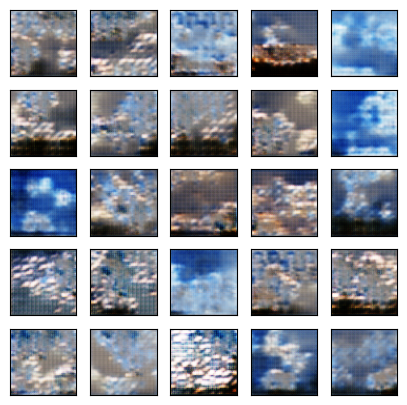

Epoch [120/200], D Loss: -0.8521, G Loss: 2.7064


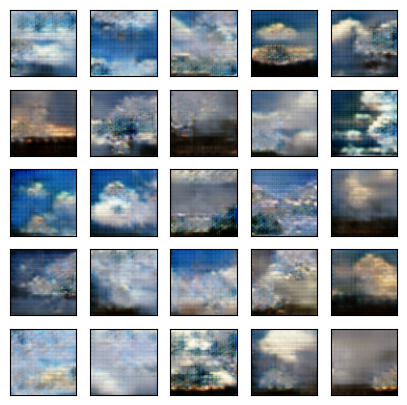

Epoch [150/200], D Loss: -1.4626, G Loss: 3.9449


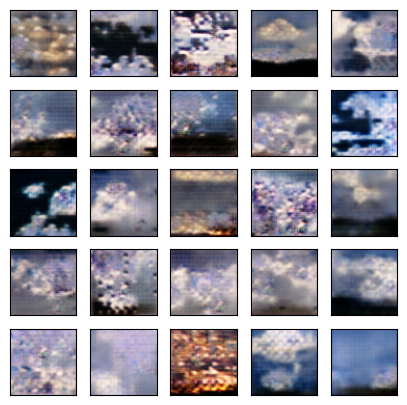

Epoch [180/200], D Loss: -1.1984, G Loss: -0.6009


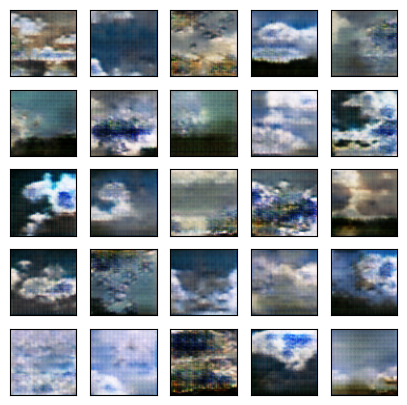

Total training time: 1213.90s


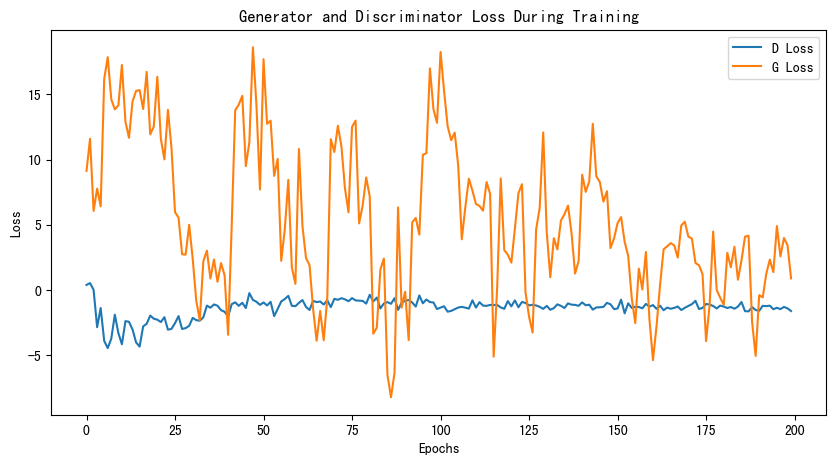

In [8]:
import os
import time
import itertools
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pyexpat.errors import codes
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn.init import xavier_uniform_
from torch.nn.utils import spectral_norm


def set_seed(seed=20):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  
set_seed(20)


class Self_Attn(nn.Module):
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = spectral_norm(nn.Conv2d(in_channels, in_channels // 8, 1, 1, 0))
        self.snconv1x1_phi = spectral_norm(nn.Conv2d(in_channels, in_channels // 8, 1, 1, 0))
        self.snconv1x1_g = spectral_norm(nn.Conv2d(in_channels, in_channels // 2, 1, 1, 0))
        self.snconv1x1_attn = spectral_norm(nn.Conv2d(in_channels // 2, in_channels, 1, 1, 0))
        self.maxpool = nn.MaxPool2d(2, 2, 0)
        self.softmax = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        theta = self.snconv1x1_theta(x).view(-1, ch // 8, h * w)
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi).view(-1, ch // 8, h * w // 4)
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        g = self.snconv1x1_g(x)
        g = self.maxpool(g).view(-1, ch // 2, h * w // 4)
        attn_g = torch.bmm(g, attn.permute(0, 2, 1)).view(-1, ch // 2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        out = x + self.sigma * attn_g
        return out


class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in sorted(os.listdir(root_dir)) if
                            f.endswith('.png') or f.endswith('.jpg')]  
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


class generator(nn.Module):
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = spectral_norm(nn.ConvTranspose2d(100, d * 8, 4, 1, 0))
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = spectral_norm(nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1))
        self.deconv2_bn = nn.BatchNorm2d(d * 4)
        self.deconv3 = spectral_norm(nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1))
        self.deconv3_bn = nn.BatchNorm2d(d * 2)
        self.self_attn = Self_Attn(d * 2)  
        self.deconv4 = spectral_norm(nn.ConvTranspose2d(d * 2, d, 4, 2, 1))
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = spectral_norm(nn.ConvTranspose2d(d, 3, 4, 2, 1))

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                xavier_uniform_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = self.self_attn(x)  
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x


class discriminator(nn.Module):
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(3, d, 4, 2, 1))
        self.conv2 = spectral_norm(nn.Conv2d(d, d * 2, 4, 2, 1))
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = spectral_norm(nn.Conv2d(d * 2, d * 4, 4, 2, 1))
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.self_attn = Self_Attn(d * 4)  
        self.conv4 = spectral_norm(nn.Conv2d(d * 4, d * 8, 4, 2, 1))
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = spectral_norm(nn.Conv2d(d * 8, 1, 4, 1, 0))

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                xavier_uniform_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = self.self_attn(x)  
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x)
        return x


def gradient_penalty(D, real_samples, fake_samples, device="cuda"):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(d_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def D_loss_wgan_gp(D, real_samples, fake_samples, lambda_gp=10, device="cuda"):
    D_real = D(real_samples)
    D_fake = D(fake_samples)
    gp = gradient_penalty(D, real_samples, fake_samples, device)
    return -torch.mean(D_real) + torch.mean(D_fake) + lambda_gp * gp

def G_loss_wgan(D_fake):
    return -torch.mean(D_fake)


batch_size = 32
lr = 0.005
train_epoch = 200
img_size = 64
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
root_dir = 'Cloud'
cloud_dataset = CloudDataset(root_dir, transform=transform)
train_loader = DataLoader(cloud_dataset, batch_size=batch_size, shuffle=False, num_workers=4,
                          worker_init_fn=lambda _: np.random.seed(int(torch.initial_seed()) % (2**32 - 1)))


G = generator(128).cuda()
D = discriminator(128).cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
D_losses = []
G_losses = []

scheduler_G = optim.lr_scheduler.StepLR(G_optimizer, step_size=100, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(D_optimizer, step_size=100, gamma=0.5)


print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_epoch_losses = []
    G_epoch_losses = []
    for x_ in train_loader:
        D.zero_grad()
        mini_batch = x_.size()[0]
        x_ = x_.cuda()
        D_result = D(x_).squeeze()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result_fake = D(G_result).squeeze()

        D_train_loss = D_loss_wgan_gp(D, x_, G_result, device="cuda")
        D_train_loss.backward()
        D_optimizer.step()
        D_epoch_losses.append(D_train_loss.item())

        G.zero_grad()
        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result = D(G_result).mean()

        G_train_loss = G_loss_wgan(D_result)
        G_train_loss.backward()
        G_optimizer.step()
        G_epoch_losses.append(G_train_loss.item())

    scheduler_G.step()
    scheduler_D.step()

    if (epoch + 1) % 30 == 0:
        print(f'Epoch [{epoch + 1}/{train_epoch}], D Loss: {torch.mean(torch.FloatTensor(D_epoch_losses)):.4f}, G Loss: {torch.mean(torch.FloatTensor(G_epoch_losses)):.4f}')
        with torch.no_grad():
            G.eval()
            test_images = G(fixed_z_)
            G.train()

            test_images = (test_images + 1) / 2
            test_images = torch.clamp(test_images, 0, 1)
            size_figure_grid = 5
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
            for k in range(5 * 5):
                i = k // 5
                j = k % 5
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k].permute(1, 2, 0).cpu().numpy())
            plt.show()

    D_losses.append(torch.mean(torch.FloatTensor(D_epoch_losses)).item())
    G_losses.append(torch.mean(torch.FloatTensor(G_epoch_losses)).item())

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

training start!
Epoch [30/200], D Loss: -2.7473, G Loss: 4.9980


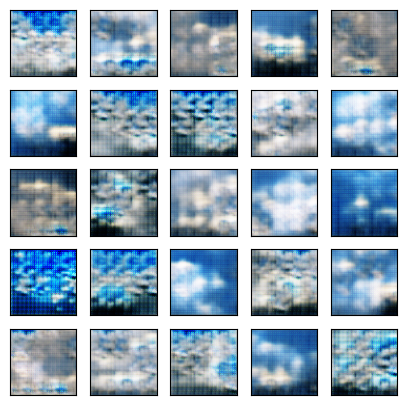

Epoch [60/200], D Loss: -1.2447, G Loss: 0.4721


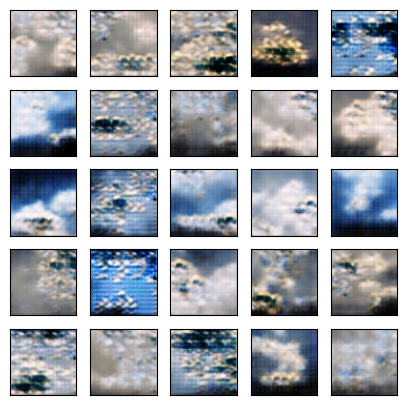

Epoch [90/200], D Loss: -0.9862, G Loss: -1.3577


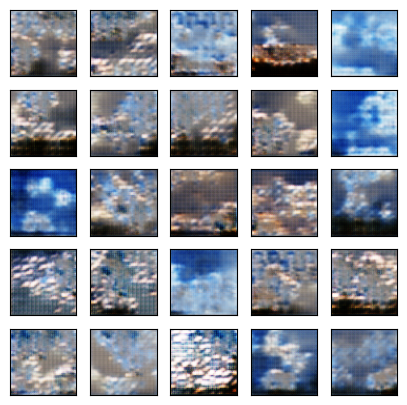

Epoch [120/200], D Loss: -0.8521, G Loss: 2.7064


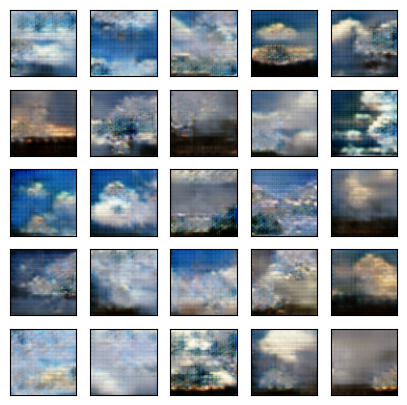

Epoch [150/200], D Loss: -1.4626, G Loss: 3.9449


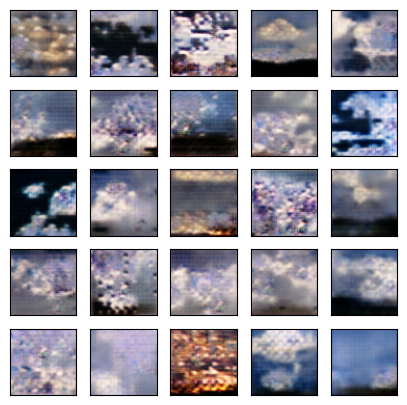

Epoch [180/200], D Loss: -1.1984, G Loss: -0.6009


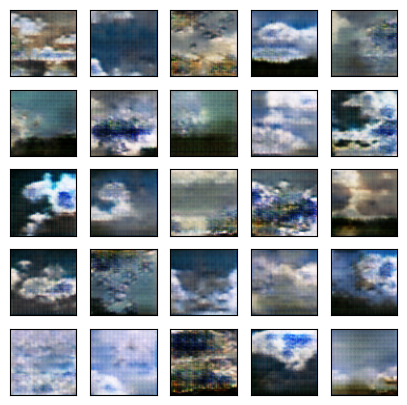

Total training time: 814.64s


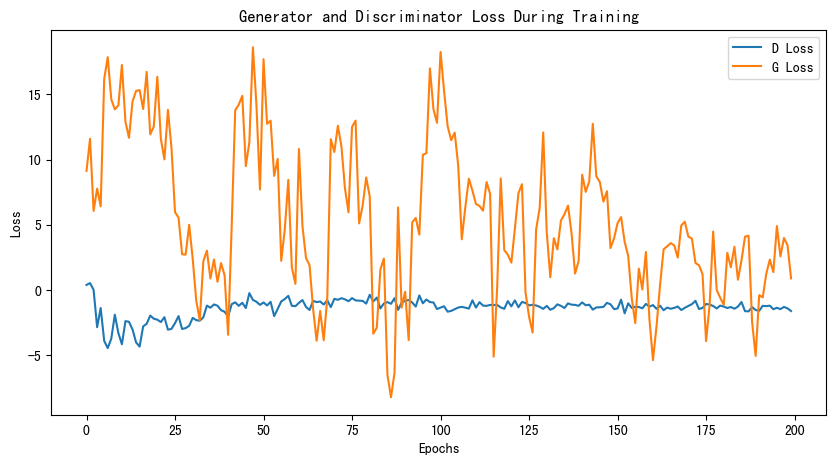

In [1]:
the same codes

From the results, it appears that two runs of the same code produce similar outcomes, proving that strategies such as setting random seeds can indeed ensure consistency in training.